In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact

# Initial Visualization: Time series of Yield

In [13]:
results = pd.read_parquet("/workspace/workflow/_6EvaluationNotebooks/results.parquet", engine="fastparquet")

# Asegurar formato de fecha
results["Clock.Today"] = pd.to_datetime(results["Clock.Today"])

# Lista de variables disponibles
possible_vars = ['MaizeYield','SoyBeanYield','Maize.Root.Total.Wt','Maize.Leaf.Total.Wt','Maize.IsAlive','soybean.Root.Total.Wt','Nitrogen_Sowing']

@interact(variable=possible_vars)
def plot_variable(variable="SurfaceOrganicMatter.Cover"):
    # Usar pivot_table para evitar error por duplicados
    pivot_df = results.pivot_table(
        index="Clock.Today",
        columns="Nitrogen",
        values=variable,
        aggfunc="mean"  # Puedes usar "first" o "sum" según el caso
    )

    plt.figure(figsize=(12, 6))
    for col in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[col], label=f"Nitrogen {col}")

    plt.xlabel("Date")
    plt.ylabel("Yield")
    plt.title(f"{"SurfaceOrganicMatter.Cover"} over time")
    plt.legend(title="Simulation", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()




interactive(children=(Dropdown(description='variable', options=('MaizeYield', 'SoyBeanYield', 'Maize.Root.Tota…

# Comparison with ground Truth Data

In [52]:
indiana_info=pd.read_csv("/workspace/workflow/_6EvaluationNotebooks/NRCS_N_project_Indiana_dataset_2025.04.csv")
ground_truth=indiana_info[['County','Year','FieldID','PreCrop','rTN_lbac','rY15_mtha']]
ground_truth.shape

(2812, 6)

In [15]:
print(ground_truth.Year.unique())
print(ground_truth.County.unique())

[22 23 21]
['White' 'Randolph' 'Dubois' 'Marshall' 'Clay']


In [16]:
ground_truth["County"] = ground_truth["County"].replace({
    "White": "White County",
    "Randolph": "Randolph County",
    "Dubois": "Dubois County",
    "Marshall": "Marshall County",
    "Clay": "Clay County"
})

/tmp/ipykernel_27363/1375266808.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
import geopandas as gpd
import os
import glob
folder = "/workspace/workflow/_3AgroDataExtraction"
geojson_file = glob.glob(os.path.join(folder, "*.geojson"))
fields=gpd.read_file(geojson_file[0])
fields

,id_cell,id_within_cell,index_right,region,countyname,geometry
0,379,3,66,NC,Clay County,"MULTIPOLYGON (((-87.13516 39.54949, -87.13516 ..."
1,376,3,66,NC,Clay County,"MULTIPOLYGON (((-87.15267 39.2635, -87.15267 3..."
2,334,4,66,NC,Clay County,"MULTIPOLYGON (((-87.18142 39.56288, -87.18142 ..."
3,379,4,66,NC,Clay County,"MULTIPOLYGON (((-87.10651 39.51795, -87.10651 ..."
4,332,1,66,NC,Clay County,"MULTIPOLYGON (((-87.21611 39.40065, -87.21611 ..."
...,...,...,...,...,...,...
70,573,1,89,NC,White County,"MULTIPOLYGON (((-86.66264 40.84507, -86.66264 ..."
71,436,3,89,NC,White County,"MULTIPOLYGON (((-87.00952 40.63859, -87.00946 ..."
72,529,2,89,NC,White County,"MULTIPOLYGON (((-86.75023 40.87562, -86.75149 ..."
73,483,3,89,NC,White County,"MULTIPOLYGON (((-86.9031 40.80996, -86.9031 40..."


In [46]:
predicted =pd.read_parquet("/workspace/workflow/_6EvaluationNotebooks/results.parquet",engine="fastparquet")
predicted.county.unique()

array(['Clay County'], dtype=object)

In [41]:
predicted =pd.read_parquet("/workspace/workflow/_6EvaluationNotebooks/results.parquet",engine="fastparquet")
predicted['Yield'] = (predicted['MaizeYield']+predicted['SoyBeanYield'])/1000
predicted = predicted[['Clock.Today','Yield','Nitrogen','id_cell','id_within_cell']]
predicted = predicted[predicted["Yield"] != 0]
predicted

,Clock.Today,Yield,Nitrogen,id_cell,id_within_cell
182,2021-07-02,0.044937,0,379,3
183,2021-07-03,0.098806,0,379,3
184,2021-07-04,0.174423,0,379,3
185,2021-07-05,0.261477,0,379,3
186,2021-07-06,0.350728,0,379,3
...,...,...,...,...,...
11626,2024-10-31,1.265673,300,376,3
11627,2024-11-01,1.265673,300,376,3
11628,2024-11-02,1.265673,300,376,3
11629,2024-11-03,1.265673,300,376,3


In [44]:
predicted.id_cell.unique()

array([379, 376])

In [36]:
folder = "/workspace/workflow/_3AgroDataExtraction"
geojson_file = glob.glob(os.path.join(folder, "*.geojson"))
fields_counties=gpd.read_file(geojson_file[0])
fields_counties=fields_counties[['id_cell','id_within_cell','countyname','region']]
fields_counties.head(6)

,id_cell,id_within_cell,countyname,region
0,379,3,Clay County,NC
1,376,3,Clay County,NC
2,334,4,Clay County,NC
3,379,4,Clay County,NC
4,332,1,Clay County,NC
5,424,4,Clay County,NC


In [37]:
predicted_counties= pd.merge(
    predicted,
    fields_counties,
    on=['id_cell'], 
    how='inner'          
)
print(predicted_counties.region.unique())
predicted_counties


['NC']


,Clock.Today,Yield,Nitrogen,id_cell,id_within_cell_x,id_within_cell_y,countyname,region
0,2021-07-02,0.044937,0,379,3,3,Clay County,NC
1,2021-07-02,0.044937,0,379,3,4,Clay County,NC
2,2021-07-03,0.098806,0,379,3,3,Clay County,NC
3,2021-07-03,0.098806,0,379,3,4,Clay County,NC
4,2021-07-04,0.174423,0,379,3,3,Clay County,NC
...,...,...,...,...,...,...,...,...
5195,2024-11-02,1.265673,300,376,3,2,Clay County,NC
5196,2024-11-03,1.265673,300,376,3,3,Clay County,NC
5197,2024-11-03,1.265673,300,376,3,2,Clay County,NC
5198,2024-11-04,1.265673,300,376,3,3,Clay County,NC


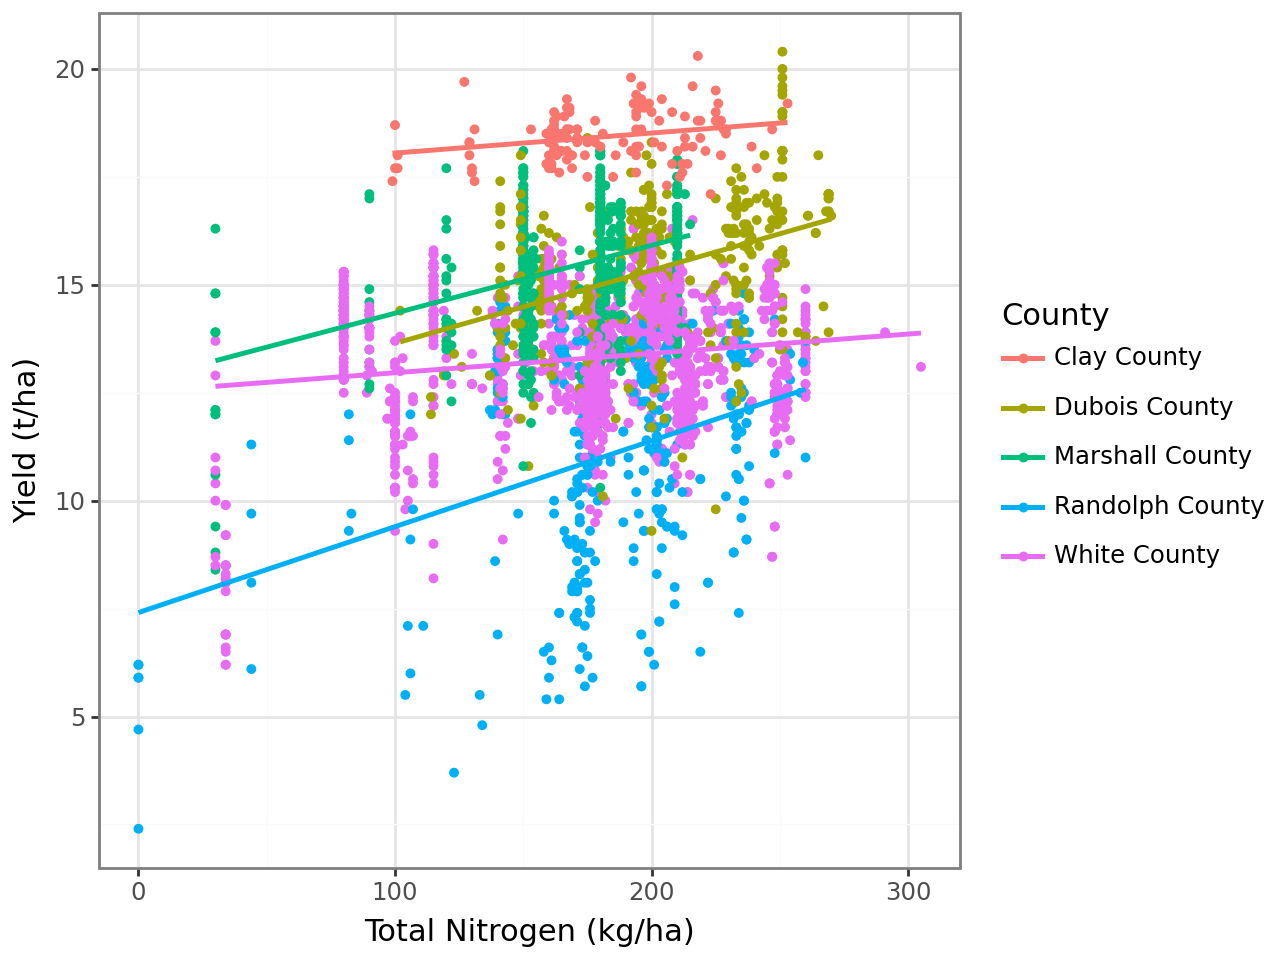

In [22]:
from plotnine import ggplot, aes, geom_point, geom_smooth, labs, theme_bw

plot = (
    ggplot(ground_truth, aes(x='rTN_lbac', y='rY15_mtha', color='County')) +
    geom_point(size=1) +
    geom_smooth(method='lm', se=False) +
    theme_bw() +
    labs(
        x='Total Nitrogen (kg/ha)',
        y='Yield (t/ha)',
        color='County'
    )
)

plot.show()

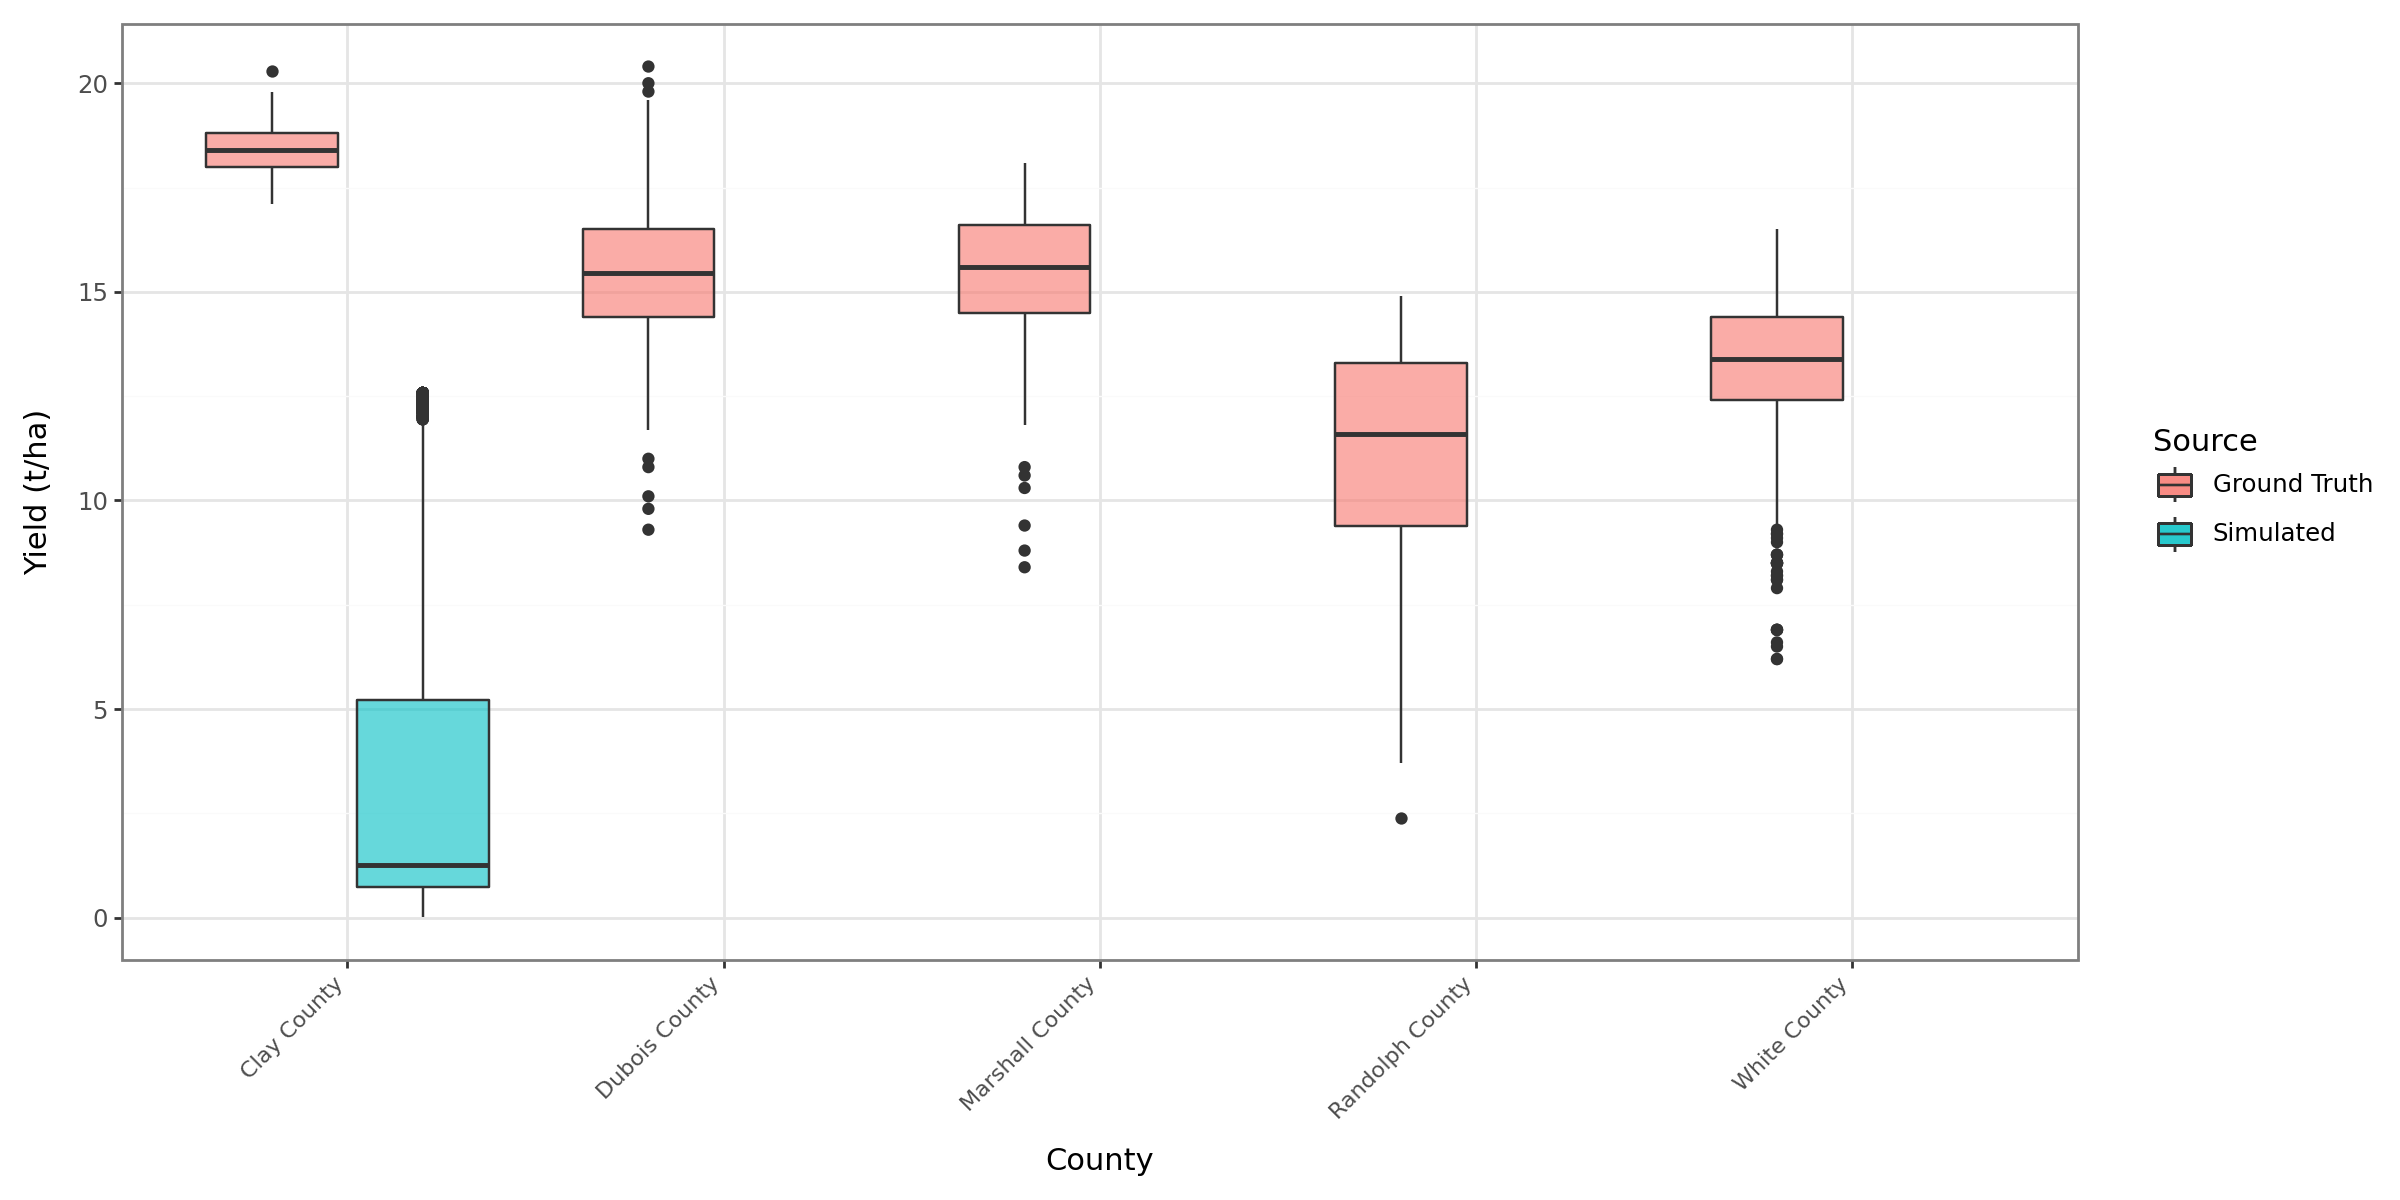

In [31]:
from plotnine import *
plot = (
    ggplot() +
    # Boxplots de valores observados
    geom_boxplot(
        data=ground_truth,
        mapping=aes(x='County', y='rY15_mtha', fill='"Ground Truth"'),
        position=position_nudge(x=-0.2),
        width=0.35,
        alpha=0.6
    ) +
    geom_boxplot(
        data=predicted_counties,
        mapping=aes(x='countyname', y='Yield', fill='"Simulated"'),
        position=position_nudge(x=0.2),
        width=0.35,
        alpha=0.6
    ) +
    theme_bw() +
    labs(
        x='County',
        y='Yield (t/ha)',
        fill='Source'
    )+
    theme(
        axis_text_x=element_text(size=8, angle=45, hjust=1),  # 🔹 tamaño y rotación
        figure_size=(12, 6)  # 🔹 hace el gráfico más ancho directamente
    )
)

plot.show()

In [48]:
ground_truth_onecounty=ground_truth[ground_truth['County']=='Clay County']
ground_truth_onecounty

,County,Year,FieldID,PreCrop,rTN_lbac,rY15_mtha
2682,Clay County,22,TY_22,Soybean,160,17.7
2683,Clay County,22,TY_22,Soybean,163,18.1
2684,Clay County,22,TY_22,Soybean,162,18.2
2685,Clay County,22,TY_22,Soybean,160,18.0
2686,Clay County,22,TY_22,Soybean,169,17.7
...,...,...,...,...,...,...
2807,Clay County,22,TY_22,Soybean,195,19.2
2808,Clay County,22,TY_22,Soybean,216,18.2
2809,Clay County,22,TY_22,Soybean,208,19.0
2810,Clay County,22,TY_22,Soybean,204,18.2


In [50]:
predicted_counties_onecounty=predicted_counties[predicted_counties['countyname']=='Clay County']
predicted_counties_onecounty

,Clock.Today,Yield,Nitrogen,id_cell,id_within_cell_x,id_within_cell_y,countyname,region
0,2021-07-02,0.044937,0,379,3,3,Clay County,NC
1,2021-07-02,0.044937,0,379,3,4,Clay County,NC
2,2021-07-03,0.098806,0,379,3,3,Clay County,NC
3,2021-07-03,0.098806,0,379,3,4,Clay County,NC
4,2021-07-04,0.174423,0,379,3,3,Clay County,NC
...,...,...,...,...,...,...,...,...
5195,2024-11-02,1.265673,300,376,3,2,Clay County,NC
5196,2024-11-03,1.265673,300,376,3,3,Clay County,NC
5197,2024-11-03,1.265673,300,376,3,2,Clay County,NC
5198,2024-11-04,1.265673,300,376,3,3,Clay County,NC


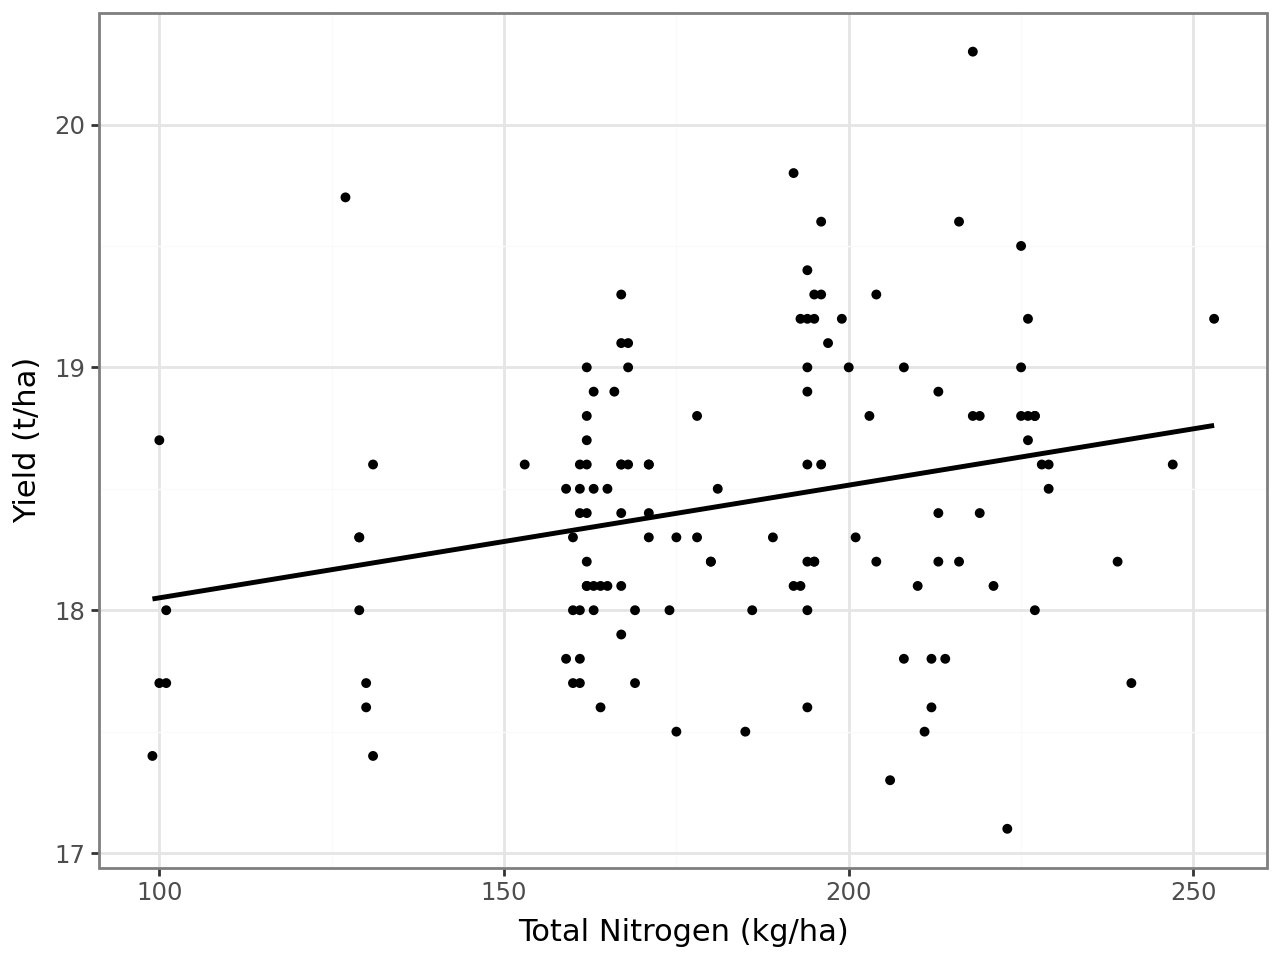

In [51]:
from plotnine import ggplot, aes, geom_point, geom_smooth, labs, theme_bw

plot = (
    ggplot(ground_truth_onecounty, aes(x='rTN_lbac', y='rY15_mtha')) +
    geom_point(size=1) +
    geom_smooth(method='lm', se=False) +
    theme_bw() +
    labs(
        x='Total Nitrogen (kg/ha)',
        y='Yield (t/ha)',
        color='County'
    )
)

plot.show()